In [20]:
import numpy as np
import pandas as pd
import tempfile
import os
import os.path
import wave
from IPython.display import Audio, display
import matplotlib.pylab as plt
from scipy import stats
import librosa
from pathlib import Path

C:\Users\antos\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


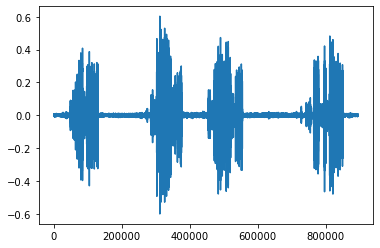

In [7]:
file = r'./data/Acrocephalus-arundinaceus-131536.mp3'

x, fs = librosa.load(file)
plt.plot(x)
plt.show()

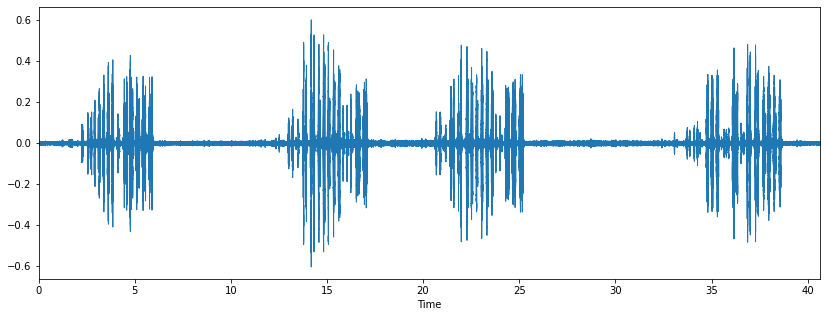

In [8]:
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=fs)
plt.show()

In [12]:
import IPython.display as ipd
ipd.Audio(x, rate=fs)

(513, 3500)


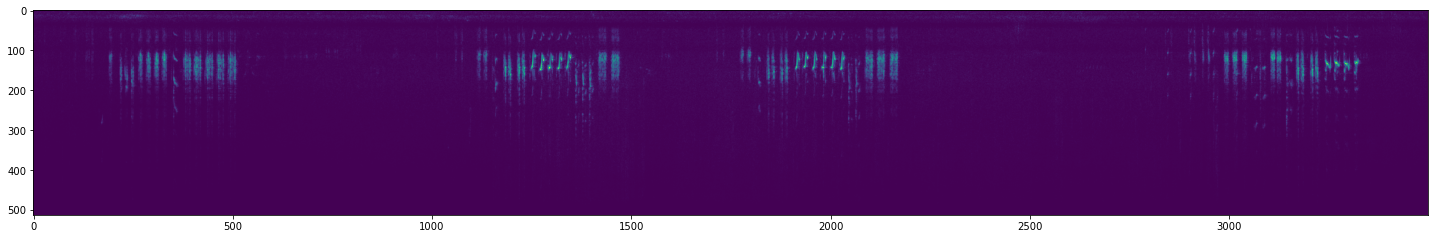

In [19]:
WINDOW_SIZE = 1024
y = librosa.stft(x, n_fft = WINDOW_SIZE)#, hop_length = 512)

y = np.log1p(np.abs(y))
print(y.shape)

plt.figure(figsize=(25,25))
plt.imshow(y)
plt.show()

In [21]:
pd.read_csv(r'metadata.csv')

,Recording_ID,Genus,Specific_epithet,Subspecies,English_name,Recordist,Country,Locality,Latitude,Longitude,...,Other_species23,Other_species24,Other_species25,Other_species26,Other_species27,Other_species28,Other_species29,Other_species30,Species,Path
0,356824,Sonus,naturalis,NaN,Soundscape,José Carlos Sires,Spain,"doñana visitable, sevilla, andalucía",37.1058,-6.2577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonus naturalis,mp3//Sonus-naturalis-356824.mp3
1,317951,Sonus,naturalis,NaN,Soundscape,José Carlos Sires,Spain,"arroyo algarbe, hinojos, huelva, andalucía",37.3006,-6.3783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonus naturalis,mp3//Sonus-naturalis-317951.mp3
2,508571,Sonus,naturalis,NaN,Soundscape,Nelson Conceição,Portugal,"Santo Estêvão, Tavira, Faro",37.1554,-7.6960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonus naturalis,mp3//Sonus-naturalis-508571.mp3
3,448534,Sonus,naturalis,NaN,Soundscape,José Carlos Sires,Spain,"Córdoba, Córdoba, Andalucía",37.9321,-4.9446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonus naturalis,mp3//Sonus-naturalis-448534.mp3
4,373414,Sonus,naturalis,NaN,Soundscape,Lars Lachmann,Germany,"Frohnau, Berlin, north-eastern part",52.6408,13.2956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sonus naturalis,mp3//Sonus-naturalis-373414.mp3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,518681,Glaucidium,passerinum,NaN,Eurasian Pygmy Owl,Daniele Baroni,Finland,"Nousis, Åbo, Southwest Finland",60.6657,22.2822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,mp3//Glaucidium-passerinum-518681.mp3
2146,401901,Glaucidium,passerinum,passerinum,Eurasian Pygmy Owl,Jarek Matusiak,Russian Federation,"Gmina Dubeninki, Nesterovsky District, Kalinin...",54.3490,22.6561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,mp3//Glaucidium-passerinum-401901.mp3
2147,201176,Glaucidium,passerinum,passerinum,Eurasian Pygmy Owl,Bram Piot,France,"Haut-Jura, Farges, Ain",46.1716,5.8689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,mp3//Glaucidium-passerinum-201176.mp3
2148,408254,Glaucidium,passerinum,NaN,Eurasian Pygmy Owl,Miklos Heincz,Hungary,"Velem, Kőszegi, Vas County",47.3411,16.4901,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glaucidium passerinum,mp3//Glaucidium-passerinum-408254.mp3
